In [1]:
import numpy as np
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# sbi
from sbi import utils as utils
from sbi.inference.base import infer

%load_ext autoreload
%autoreload 2
%matplotlib inline

# SNPE_C (APT)

__Author:__ Ji Won Park (@jiwoncpark)

__Created:__ 1/02/2021

__Last run:__ 1/02/2021

We'll run APT on our strong lensing data.

__Before running:__

- Install `sbi`, a super streamlined package for doing simulation-based inference.

```bash
pip install sbi
```

- Install `baobab`, my own package for generating strong lensing training sets. It's under active development so you're best off installing the latest version.

```bash
# Install Fortran dependency
sudo apt-get install gfortran
git clone https://github.com/sibirrer/fastell4py.git <desired location>
cd <desired location>/fastell4py
python setup.py install --user
# Install baobab
git clone https://github.com/jiwoncpark/baobab.git
cd baobab
pip install -e . -r requirements.txt
```

In [2]:
from baobab.sim_utils.image_utils import Imager2

# Instantiate Imager2, which will render the image
imager = Imager2(lens_model_list=['PEMD', 'SHEAR'], 
                 src_model_list=['SERSIC_ELLIPSE'],
                 n_pix=64, pixel_scale=0.08, 
                 psf_type='PIXEL',
                 psf_kernel_size=91,
                 which_psf_maps=[101])
# Tell it information about the telescope survey
imager.survey_kwargs = dict(
                           survey_name="HST",
                           bandpass_list=["TDLMC_F160W"],
                           override_obs_kwargs=dict(
                                                    exposure_time=5400.0
                                                    )
                           )
# Wrapper around imager that takes parameters to 
# observation
def simulation_wrapper(params):
    # Draw params that aren't inferred
    mag = np.random.rand()*4.0 + 18.0 # U([18, 22]
    n_sersic = max(np.random.randn()*0.5 + 3.0, 1.0) # N(3, 0.5)
    imager.lens_kwargs = [dict(center_x=params[0], center_y=params[1],
                               e1=params[2], e2=params[3],
                               gamma=params[4], theta_E=params[5]),
                          dict(gamma1=params[6], gamma2=params[7])]
    imager.src_kwargs = [dict(center_x=params[8], center_y=params[9],
                              e1=params[10], e2=params[11],
                              magnitude=mag,
                              n_sersic=n_sersic,
                              R_sersic=params[12])]
    image = imager.generate_image().squeeze().reshape(-1)
    return image

In [9]:
param_labels = ['x_lens', 'y_lens', 'e1_lens', 'e2_lens', 'gamma', 'theta_E']
param_labels += ['g1', 'g2']
param_labels += ['x_src', 'y_src', 'e1_src', 'e2_src', 'R_src']

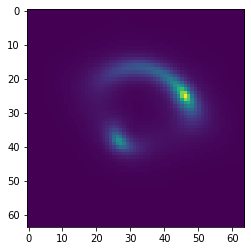

In [3]:
true_params = np.array([0, 0, -0.1, -0.1, 2.0, 1.0, 0.005, -0.005, 0.2, -0.2, 0.3, 0.2, 0.35])
test_img = simulation_wrapper(true_params)
plt.imshow(test_img.reshape(64, 64))

In [4]:
prior_min = [-0.1, -0.1, -0.4, -0.4, 1.8, 0.5] # pemd
prior_min += [-0.05, -0.05] # shear
prior_min += [-0.4, -0.4, -0.4, -0.4, 0.2] # sersic
prior_max = [0.1, 0.1, 0.4, 0.4, 2.2, 1.5] # pemd
prior_max += [0.05, 0.05] # shear
prior_max += [0.4, 0.4, 0.4, 0.4, 0.5] # sersic

In [7]:
from scipy.stats import uniform
class BoxUniformNumpy:
    def __init__(self, low, high):
        self.prior = utils.torchutils.BoxUniform(low=torch.as_tensor(low), 
                                                 high=torch.as_tensor(high))
    
    def sample(self, size):
        return self.prior.sample(size).numpy()
    
    def log_prob(self, value):
        return self.prior.log_prob(torch.as_tensor(value)).numpy()

prior = BoxUniformNumpy(low=prior_min, high=prior_max)
#print(prior.sample((2,)).shape)
#print(prior.log_prob(true_params))
#print(prior.prior.sample((2,)).shape)
#print(prior.prior.log_prob(torch.as_tensor(true_params)))

In [ ]:
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

simulator, prior = prepare_for_sbi(simulation_wrapper, prior_np)
inference = SNPE(prior)

theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=1000)
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)  # MCMC kwargs go here.


In [8]:
posterior = infer(simulation_wrapper, prior, method='SNPE', 
                  num_simulations=10000, num_workers=4)

/home/jwp/stage/sl/sbi/sbi/user_input/user_input_checks_utils.py:61: UserWarning: Prior is lacking mean attribute, estimating prior mean from samples...
  UserWarning,
/home/jwp/stage/sl/sbi/sbi/user_input/user_input_checks_utils.py:72: UserWarning: Prior is lacking variance attribute, estimating prior variance from samples...
  UserWarning,


Running 10000 simulations in 10000 batches.:   0%|          | 0/10000 [00:00<?, ?it/s]

Neural network successfully converged after 78 epochs.


In [10]:
samples = posterior.sample((10000,), 
                           x=test_img,)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

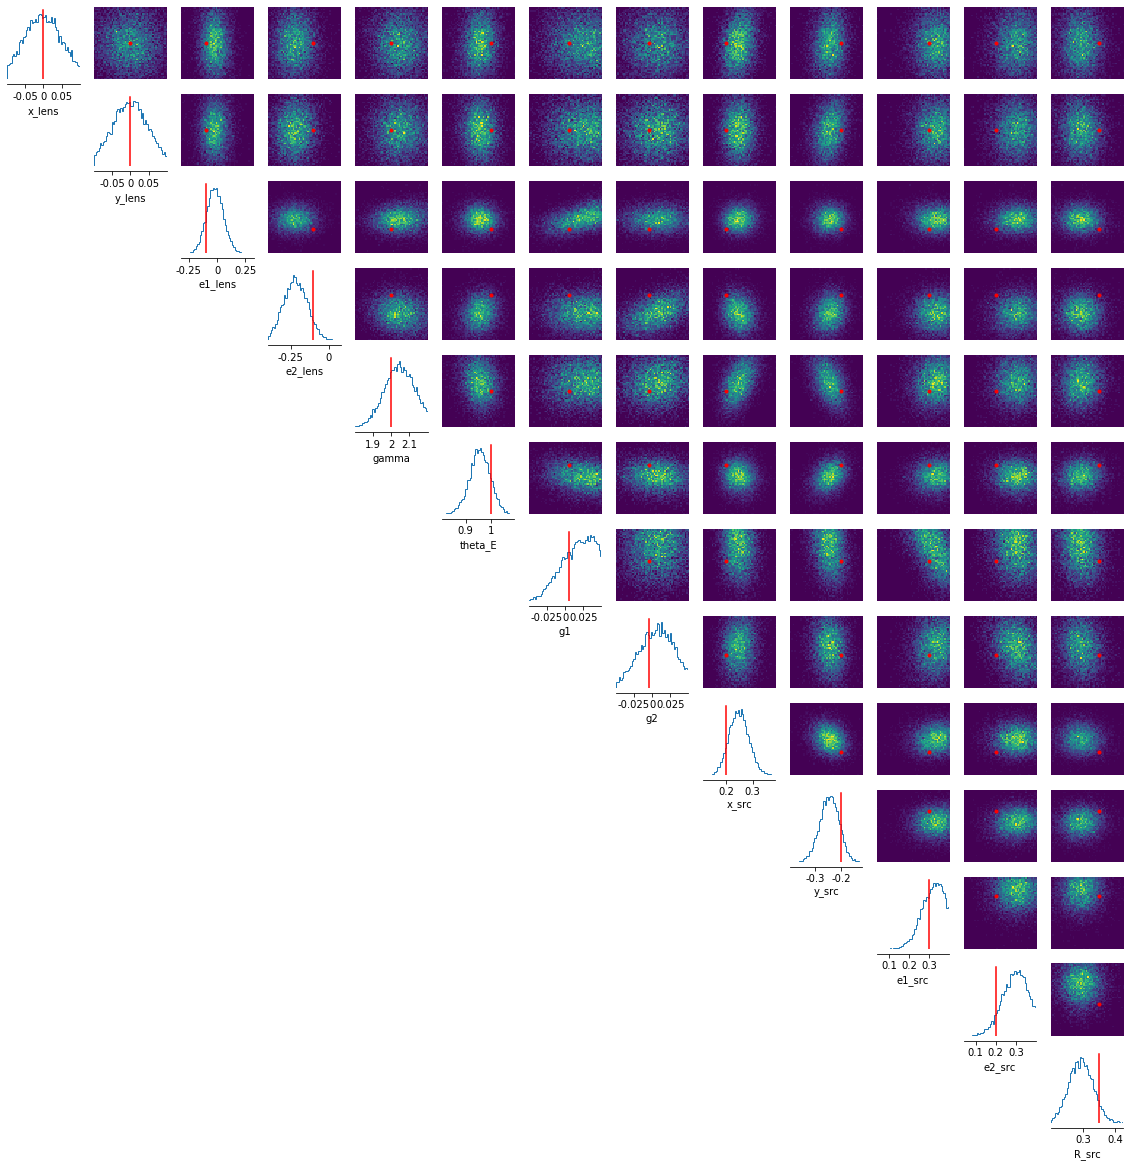

In [12]:
fig, axes = utils.pairplot(samples,
                           #limits=[[.5,80], [1e-4,15.]],
                           #ticks=[[.5,80], [1e-4,15.]],
                           fig_size=(20, 20),
                           labels=param_labels,
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r')

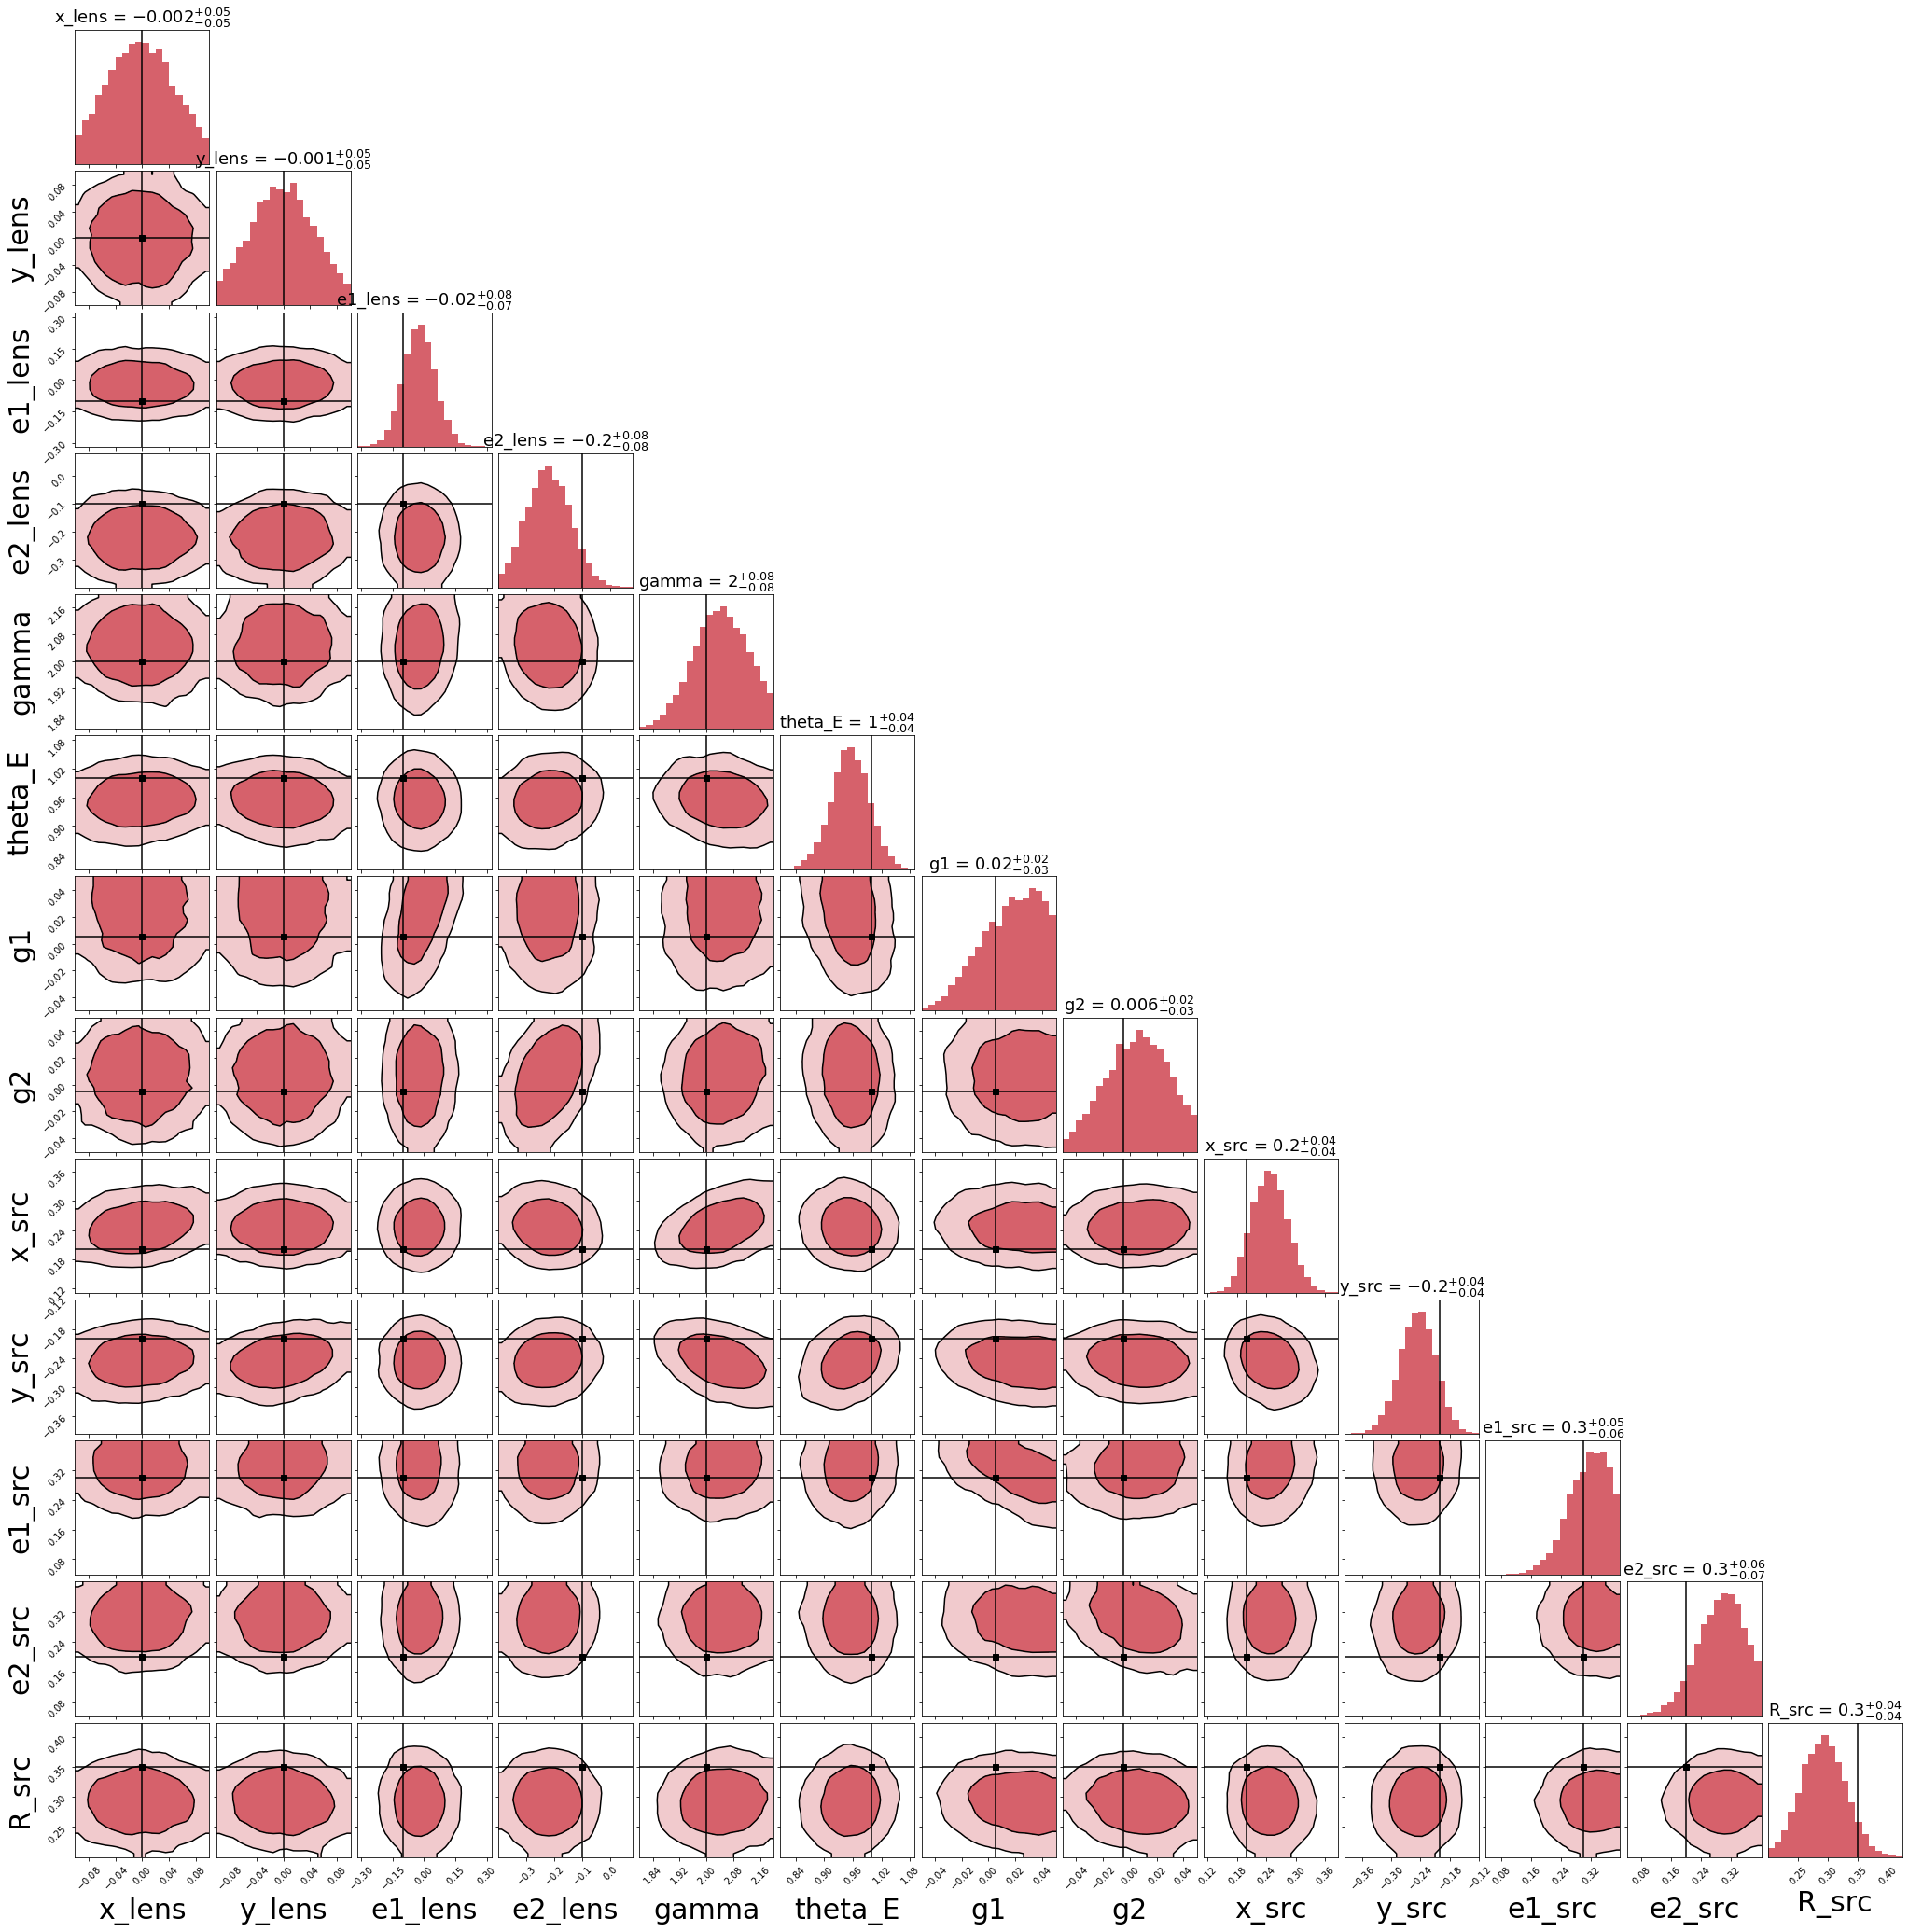

In [16]:
import corner
_ = corner.corner(samples,
                 color='#d6616b',
                 smooth=0.8,
                 alpha=1.0,
                 labels=param_labels,
                 label_kwargs={'fontsize': 30},
                 fill_contours=True,
                 plot_datapoints=False,
                 plot_contours=True,
                 show_titles=True,
                 levels=[0.68, 0.95],
                 truths=true_params,
                  truth_color='k',
                 contour_kwargs=dict(linestyles='solid', colors='k'),
                 quiet=True,
                 title_fmt=".1g",
                 title_kwargs={'fontsize': 18},
                 range=None,
                 use_math_text=True,
                 hist_kwargs=dict(density=True, histtype='stepfilled'))